In [ ]:

Standardization - zscore normalization - standard scaler
Normarization - min-max scaler
mean normalization- not used much
max abs scaling - maxabsscaler - for sparse data (not used much)
robust scaler - xi - x_median/(IQR) - (sklearn RobustScaler) - robust to outliers

Normalization vs standardization?
    most of the cases standardization
    min-max-scaler: when we know the min and max -  and we have know fixed min and max for exxample class marks,
    for the start do all.

Encoding of categorical features
    one hot 
    ordinal encoding
    label encoding - similar to ordinal encoder but used when we have categorical output


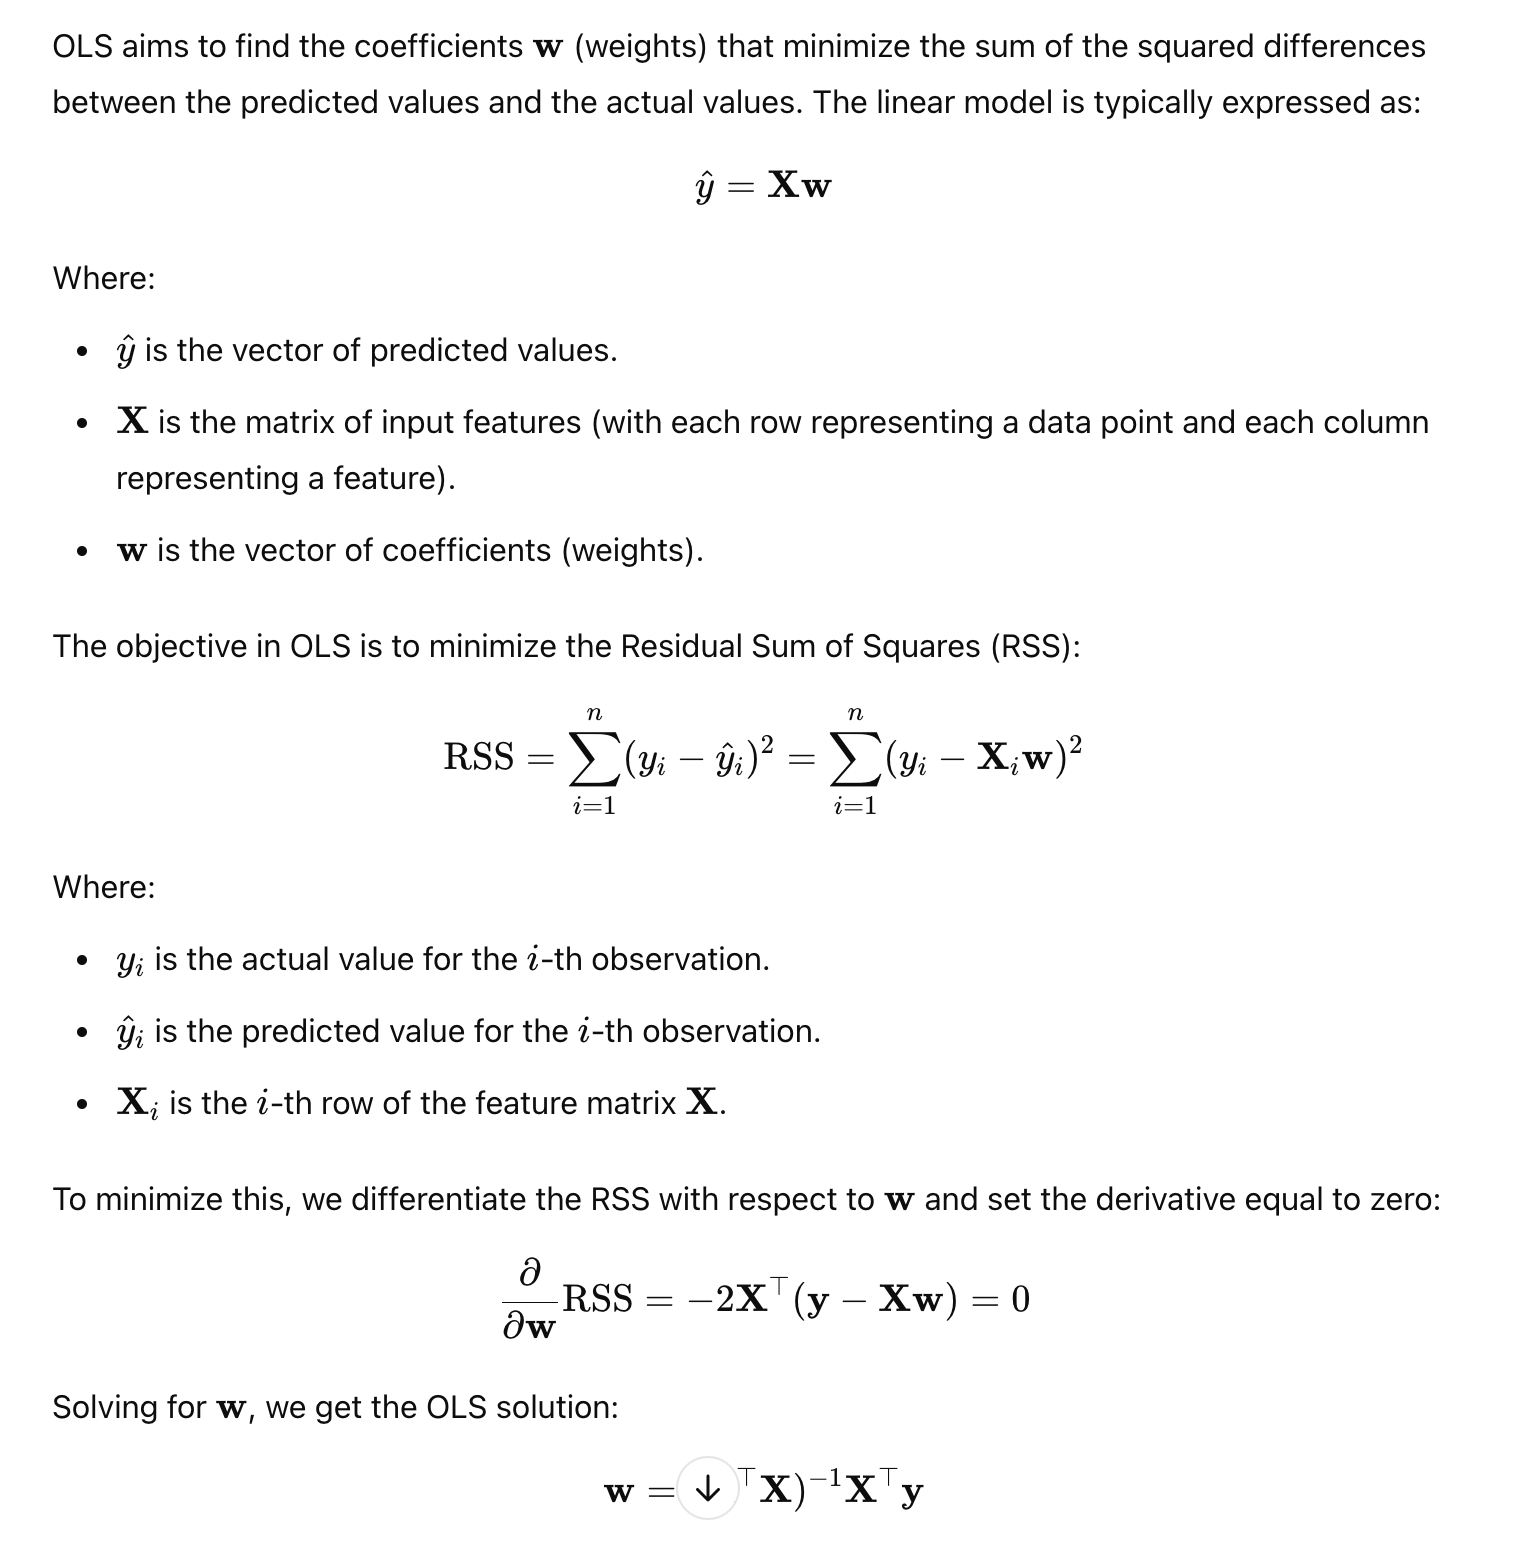

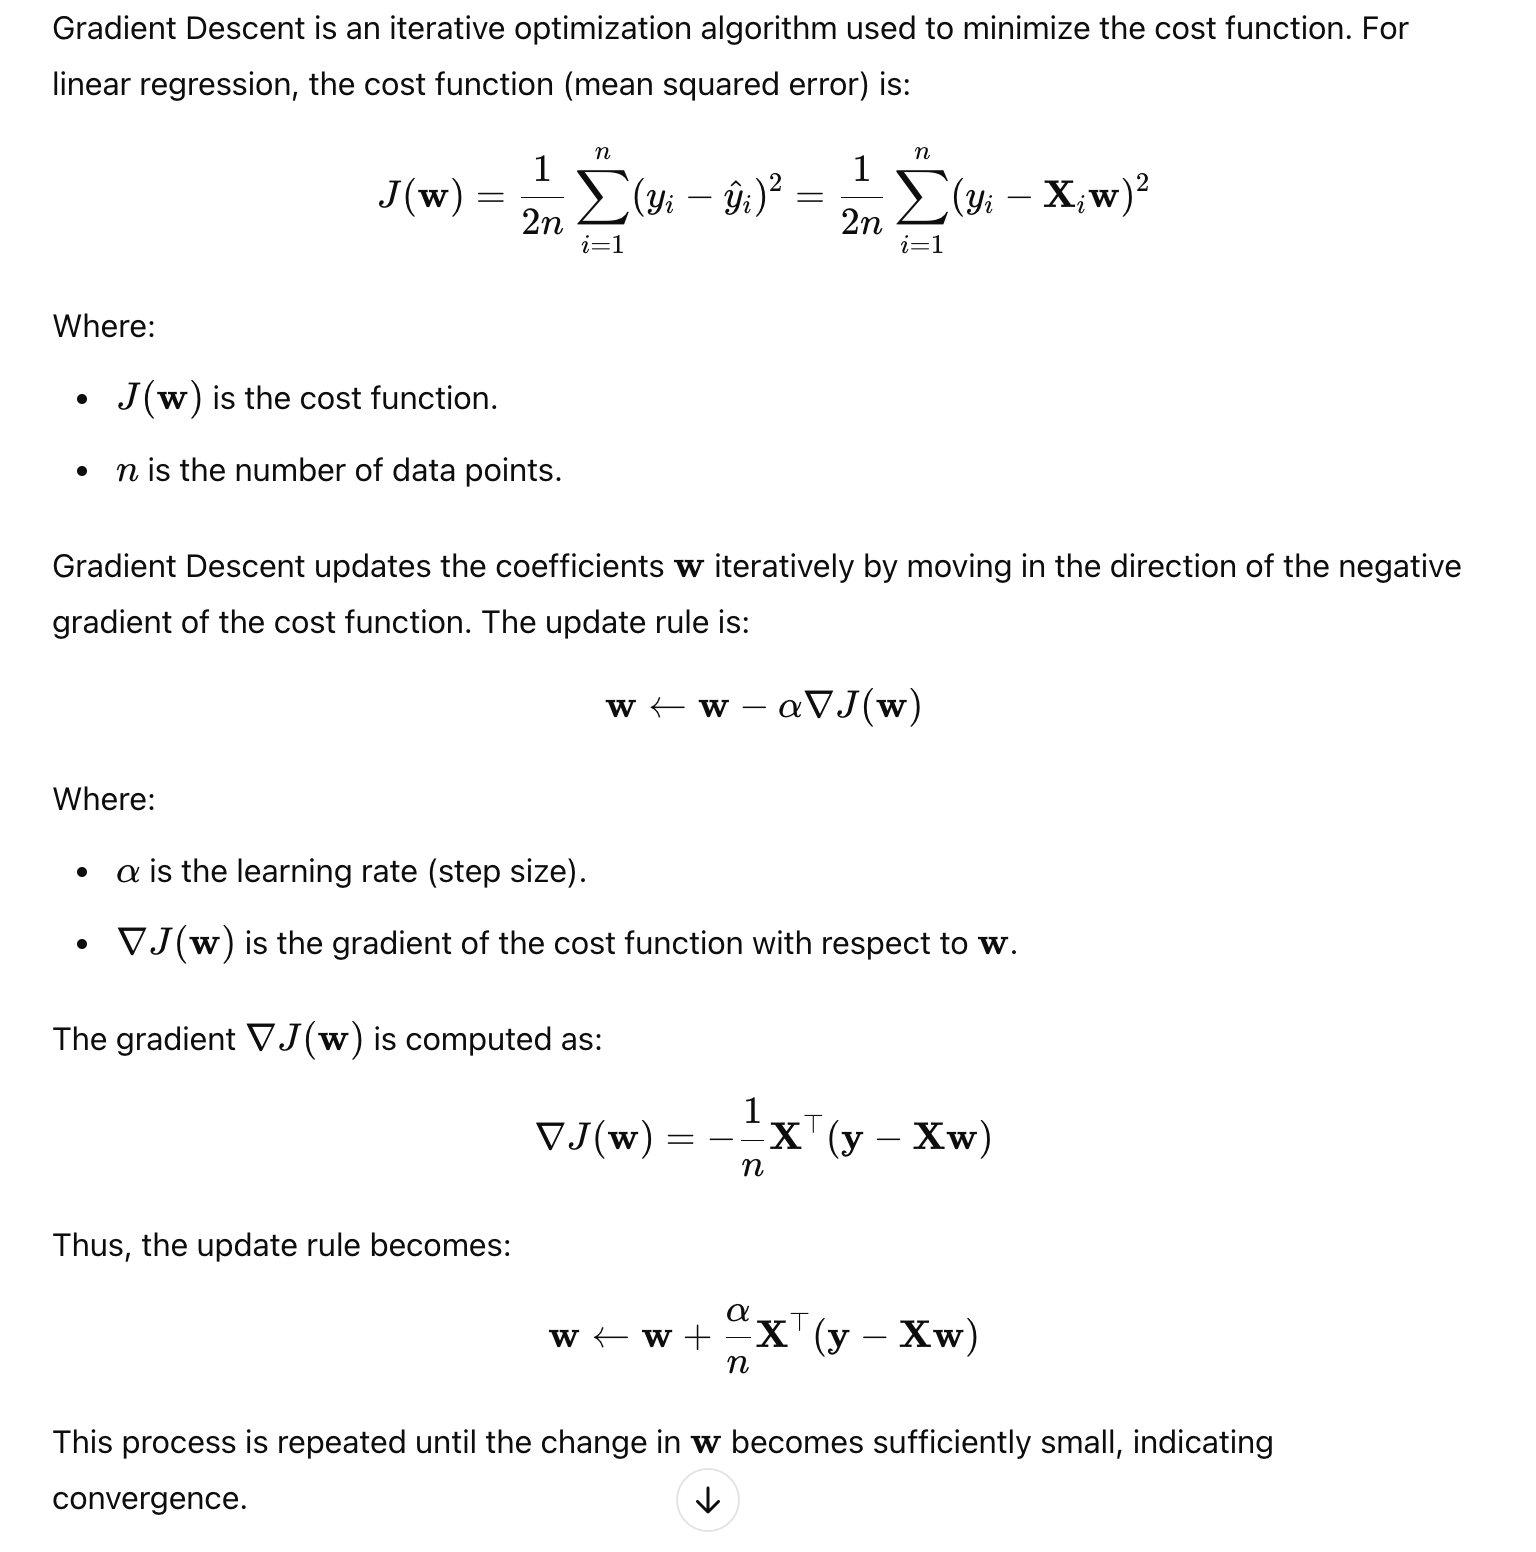

In [ ]:
When is OLS and gradient descent used?

OLS is used when data is small
For larger dataset the Matrix inverse : (X_transpose * X)^-1
becomes infeasible as wwe know that the time complexity of inverse of a matrix is (n^3)

For larger data gradient descent is used as there isnt any inverse operation on matrix
    Gradient descent is widely used because of the wide application as a minimization algortithm.

Original Data:
   Feature1  Feature2 Category OrdinalCategory
0        10         1        A             low
1        20         2        B          medium
2        30         3        A            high
3        40         4        C          medium
4      1000       100        B             low


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Transformed Data:
   Feature1  Feature2 Category OrdinalCategory  Feature1_StandardScaled  \
0        10         1        A             low                -0.538285   
1        20         2        B          medium                -0.512652   
2        30         3        A            high                -0.487019   
3        40         4        C          medium                -0.461387   
4      1000       100        B             low                 1.999343   

   Feature1_MinMaxScaled  Feature1_MaxAbsScaled  Feature1_RobustScaled  \
0               0.000000                   0.01                   -1.0   
1               0.010101                   0.02                   -0.5   
2               0.020202                   0.03                    0.0   
3               0.030303                   0.04                    0.5   
4               1.000000                   1.00                   48.5   

   Category_A  Category_B  ...  Feature1_Binned_Cut   Z_Score  \
0         1.0       

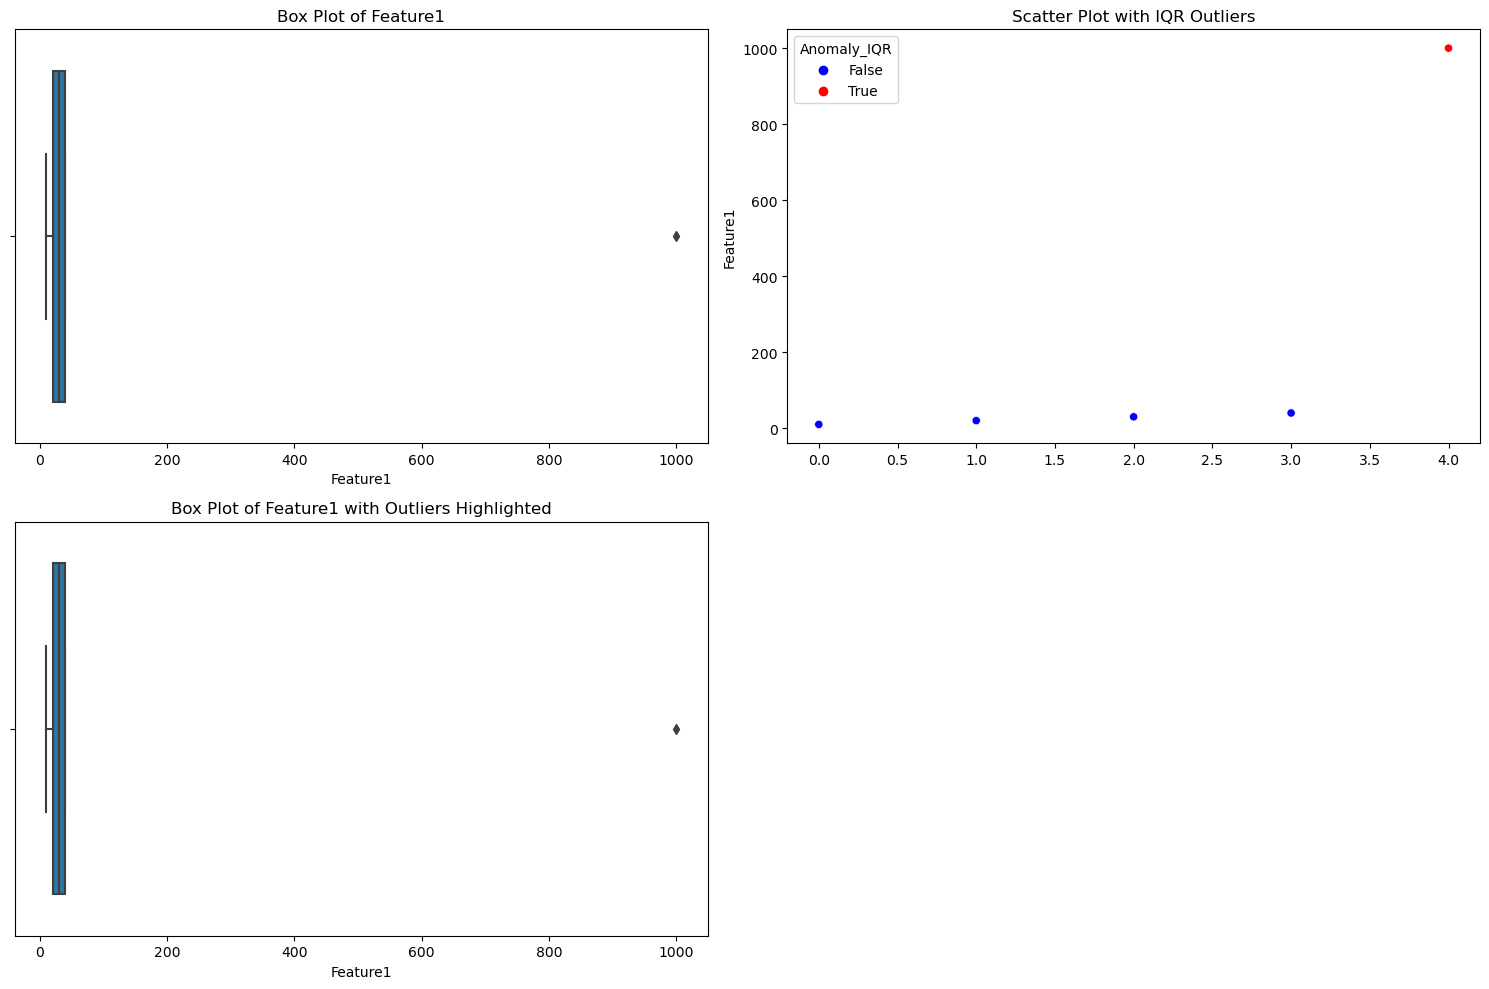


Reverted Encodings:
  Category_Reverted OrdinalCategory_Reverted Category_LabelEncoded_Reverted
0                 A                      low                              A
1                 B                   medium                              B
2                 A                     high                              A
3                 C                   medium                              C
4                 B                      low                              B


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, 
    OneHotEncoder, OrdinalEncoder, LabelEncoder, 
    PowerTransformer, KBinsDiscretizer
)
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN, KMeans
from scipy.spatial import distance
from scipy.stats import zscore, iqr

# Sample Data
data = pd.DataFrame({
    'Feature1': [10, 20, 30, 40, 1000],
    'Feature2': [1, 2, 3, 4, 100],
    'Category': ['A', 'B', 'A', 'C', 'B'],
    'OrdinalCategory': ['low', 'medium', 'high', 'medium', 'low']
})

print("Original Data:")
print(data)

# 1. Z-Score Normalization (Standard Scaler)
scaler = StandardScaler()
data['Feature1_StandardScaled'] = scaler.fit_transform(data[['Feature1']])

# 2. Min-Max Scaler
scaler = MinMaxScaler()
data['Feature1_MinMaxScaled'] = scaler.fit_transform(data[['Feature1']])

# 3. Max Abs Scaler
scaler = MaxAbsScaler()
data['Feature1_MaxAbsScaled'] = scaler.fit_transform(data[['Feature1']])

# 4. Robust Scaler
scaler = RobustScaler()
data['Feature1_RobustScaled'] = scaler.fit_transform(data[['Feature1']])

# 5. OneHot Encoding
encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = encoder.fit_transform(data[['Category']])
onehot_df = pd.DataFrame(onehot_encoded, columns=encoder.get_feature_names_out(['Category']))
data = pd.concat([data, onehot_df], axis=1)

# 6. Ordinal Encoding
ordinal_encoder = OrdinalEncoder(categories=[['low', 'medium', 'high']])
data['OrdinalCategory_Encoded'] = ordinal_encoder.fit_transform(data[['OrdinalCategory']])

# 7. Label Encoding
label_encoder = LabelEncoder()
data['Category_LabelEncoded'] = label_encoder.fit_transform(data['Category'])

# 8. Log Transform
data['Feature1_LogTransformed'] = np.log1p(data['Feature1'])  # log1p is used to avoid log(0) issues

# 9. Box-Cox Transform (only works on positive data)
# Ensure data is positive
data['Feature2_BoxCoxTransformed'] = PowerTransformer(method='box-cox').fit_transform(data[['Feature2']])

# 10. Binning using KBinsDiscretizer
binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
data['Feature1_Binned'] = binner.fit_transform(data[['Feature1']])

# 10. Binning using pd.cut
data['Feature1_Binned_Cut'] = pd.cut(data['Feature1'], bins=3, labels=False)

# Outlier Detection Methods
# 11. Z-Score Method
data['Z_Score'] = zscore(data[['Feature1']])
data_no_outliers_zscore = data[data['Z_Score'].abs() < 3]  # Removing outliers based on Z-Score

# 12. Isolation Forest
iso = IsolationForest(contamination=0.2)
data['Anomaly_IsolationForest'] = iso.fit_predict(data[['Feature1']])
data_no_outliers_iso = data[data['Anomaly_IsolationForest'] == 1]

# 13. One-Class SVM
svm = OneClassSVM(nu=0.2)
data['Anomaly_OneClassSVM'] = svm.fit_predict(data[['Feature1']])
data_no_outliers_svm = data[data['Anomaly_OneClassSVM'] == 1]

# 14. Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=2)
data['Anomaly_LOF'] = lof.fit_predict(data[['Feature1']])
data_no_outliers_lof = data[data['Anomaly_LOF'] == 1]

# 15. Elliptic Envelope
env = EllipticEnvelope(contamination=0.2)
data['Anomaly_EllipticEnvelope'] = env.fit_predict(data[['Feature1']])
data_no_outliers_env = data[data['Anomaly_EllipticEnvelope'] == 1]

# 16. DBSCAN
dbscan = DBSCAN(eps=3, min_samples=2)
data['Anomaly_DBSCAN'] = dbscan.fit_predict(data[['Feature1']])
data_no_outliers_dbscan = data[data['Anomaly_DBSCAN'] != -1]

# 17. K-Means Clustering
kmeans = KMeans(n_clusters=2)
data['Cluster_KMeans'] = kmeans.fit_predict(data[['Feature1']])
distances = np.min(distance.cdist(data[['Feature1']], kmeans.cluster_centers_, 'euclidean'), axis=1)
outliers_kmeans = distances > np.percentile(distances, 95)
data['Anomaly_KMeans'] = np.where(outliers_kmeans, -1, 1)
data_no_outliers_kmeans = data[data['Anomaly_KMeans'] == 1]

# 18. Interquartile Range (IQR) Method
Q1 = data['Feature1'].quantile(0.25)
Q3 = data['Feature1'].quantile(0.75)
IQR = Q3 - Q1
data['Anomaly_IQR'] = (data['Feature1'] < (Q1 - 1.5 * IQR)) | (data['Feature1'] > (Q3 + 1.5 * IQR))
data_no_outliers_iqr = data[~data['Anomaly_IQR']]

print("\nTransformed Data:")
print(data)

# Plotting
plt.figure(figsize=(15, 10))

# Box Plot for IQR
plt.subplot(2, 2, 1)
sns.boxplot(x=data['Feature1'])
plt.title('Box Plot of Feature1')

# Scatter Plot with Outliers
plt.subplot(2, 2, 2)
sns.scatterplot(x=data.index, y=data['Feature1'], hue=data['Anomaly_IQR'], palette={True: 'red', False: 'blue'})
plt.title('Scatter Plot with IQR Outliers')

# Box Plot for all methods
plt.subplot(2, 2, 3)
sns.boxplot(x=data['Feature1'])
plt.title('Box Plot of Feature1 with Outliers Highlighted')

plt.tight_layout()
plt.show()

# Reverting Encodings Back to Original

# Revert OneHot Encoding
reverted_category = encoder.inverse_transform(data[encoder.get_feature_names_out(['Category'])])
data['Category_Reverted'] = pd.Series(reverted_category.flatten(), index=data.index)

# Revert Ordinal Encoding
ordinal_reverted = ordinal_encoder.inverse_transform(data[['OrdinalCategory_Encoded']])
data['OrdinalCategory_Reverted'] = pd.Series(ordinal_reverted.flatten(), index=data.index)

# Revert Label Encoding
data['Category_LabelEncoded_Reverted'] = label_encoder.inverse_transform(data['Category_LabelEncoded'])

print("\nReverted Encodings:")
print(data[['Category_Reverted', 'OrdinalCategory_Reverted', 'Category_LabelEncoded_Reverted']])


In [1]:
import pandas as pd

In [7]:
df = pd.read_csv('./Linear Regression Project/Dataset/insurance.csv')

descriptive statistics
    measure of central tendancy
    measure of dispersion

EDA
    univariate
    bivariate
    mulitvariate

Transformation:
    null treatment:
        
    common:
        scaling/normalization
    numerical:
        binning: convert numerical values into categorical:
                for example: age : age bins to make groups of ages
    categorical:
        ordinal:
            ordinalencoding: categories = []
            ratings["one","two","three"]
        nominal:
            onehotencoding

    if columns are not normally distributed :
        we do convert the data into normal distrivution
            log transformation
            box cox transformation
modelling:
    model selection:
        choose all the models and fit the data
        for our case we will go for linear/polynomial regression
if the model is linear then we will also check for the assumptions of the data.

evaluation:
    choose the evaluation metrics
redo all the steps from transformation to optimize            

In [ ]:
# Basic descriptive statistics:

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [42]:
df.describe(include = 'all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


In [21]:
df.head(50)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [44]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
def category_eda(df,cols_list ):
    for cols in cols_list:
            sns.countplot(data = df,x = cols)
            plt.show()
            print (df[cols].value_counts())

In [ ]:
# univariate numerical
categorical_cols = ['sex','smoker', 'region']
numerical_cols = list(set(df.columns.tolist()) - set(cat_col_list))

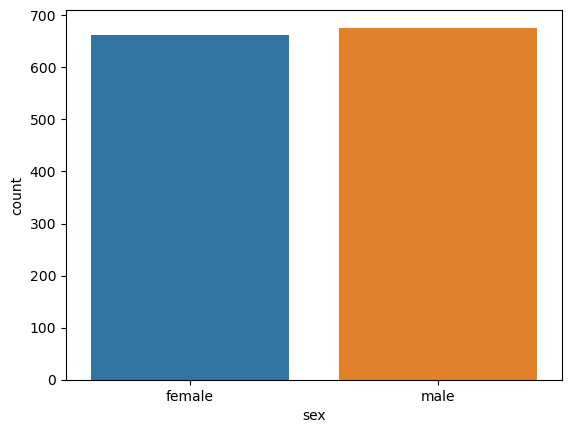

sex
male      676
female    662
Name: count, dtype: int64


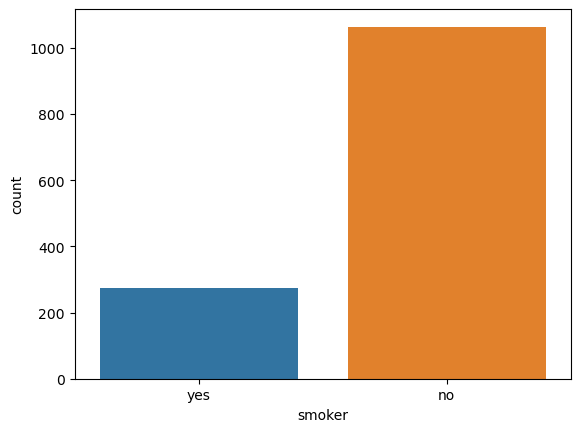

smoker
no     1064
yes     274
Name: count, dtype: int64


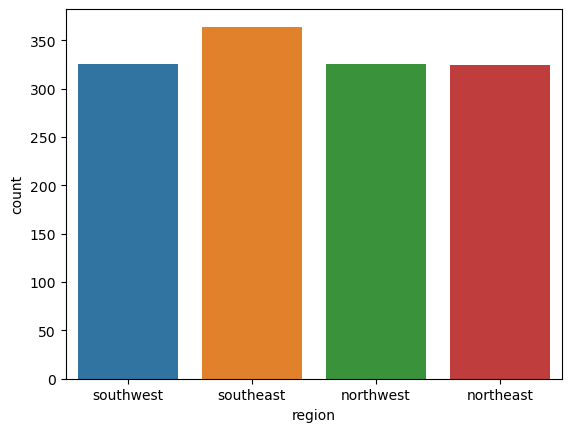

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64


In [142]:
category_eda(df,categorical_cols )

<Axes: xlabel='sex', ylabel='count'>

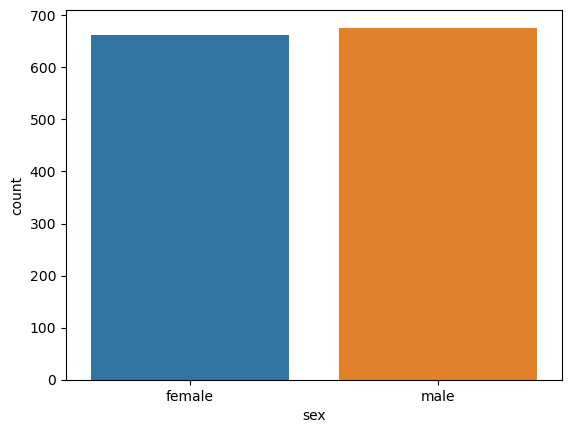

In [68]:
# univariate
    # categorical
sns.countplot(data = df,x = 'sex')

<Axes: xlabel='smoker', ylabel='count'>

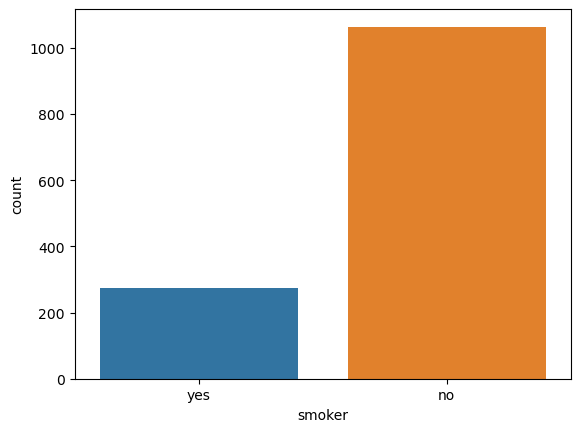

In [64]:
sns.countplot(data = df,x = 'smoker')


<Axes: xlabel='region', ylabel='count'>

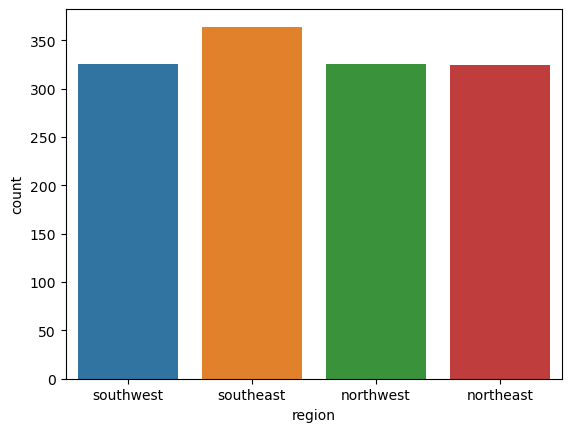

In [66]:
sns.countplot(data = df,x = 'region')

In [140]:
numerical_cols

['charges', 'children', 'age', 'bmi']

In [116]:
def numerical_eda(df,cols_list):
    for col in cols_list:
        sns.boxplot(data = df,x = col)
        plt.show()
        sns.displot(data = df,x= col,kde = True)
        plt.show()

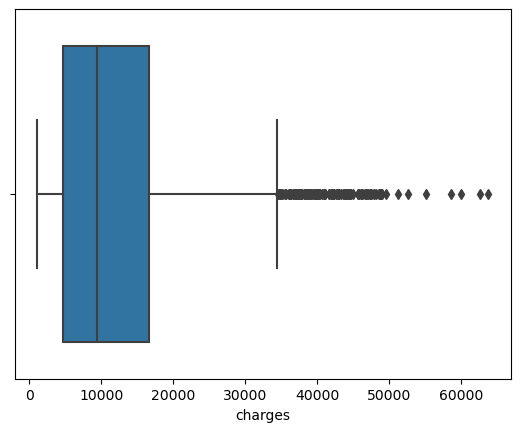

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


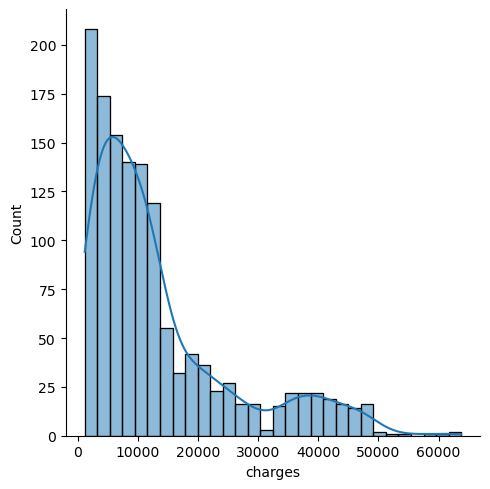

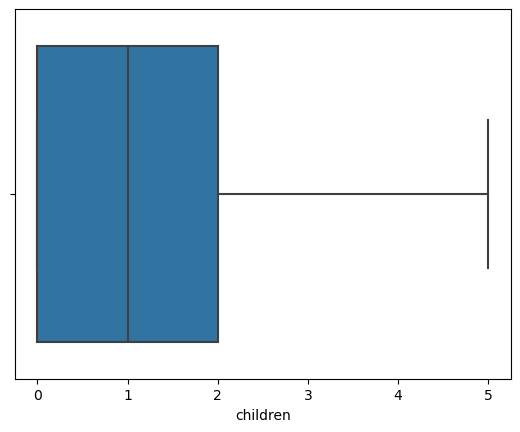

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


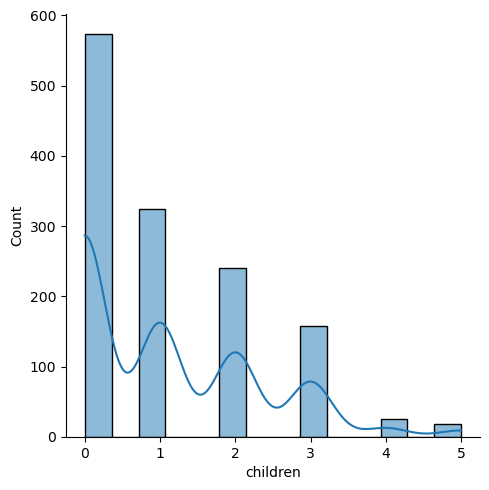

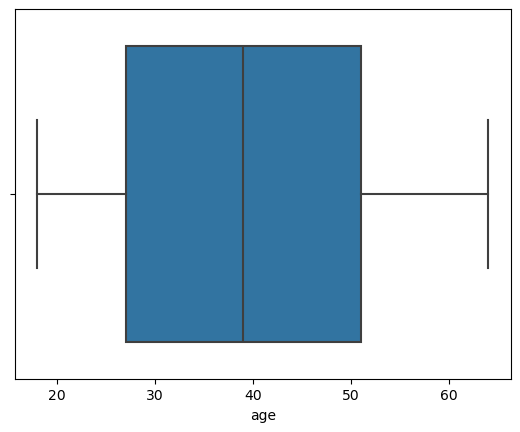

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


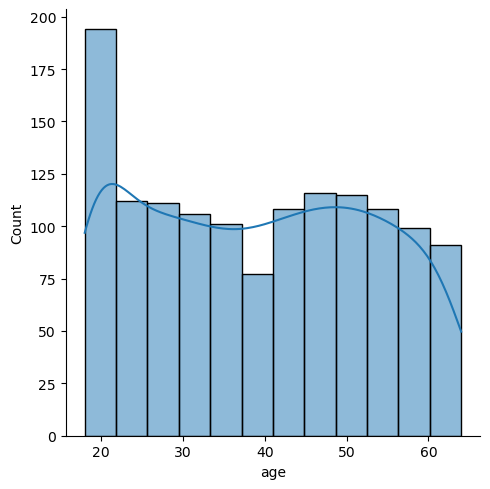

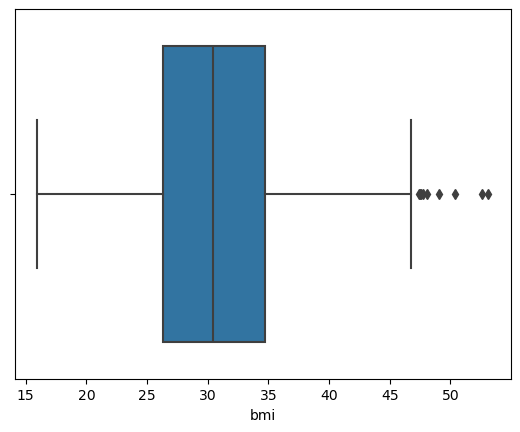

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


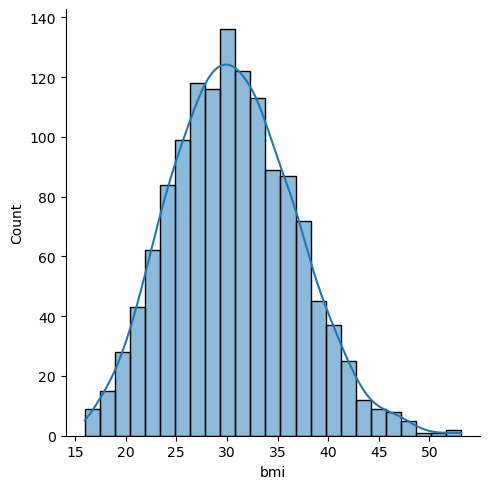

In [118]:
numerical_eda(df,numerical_cols)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

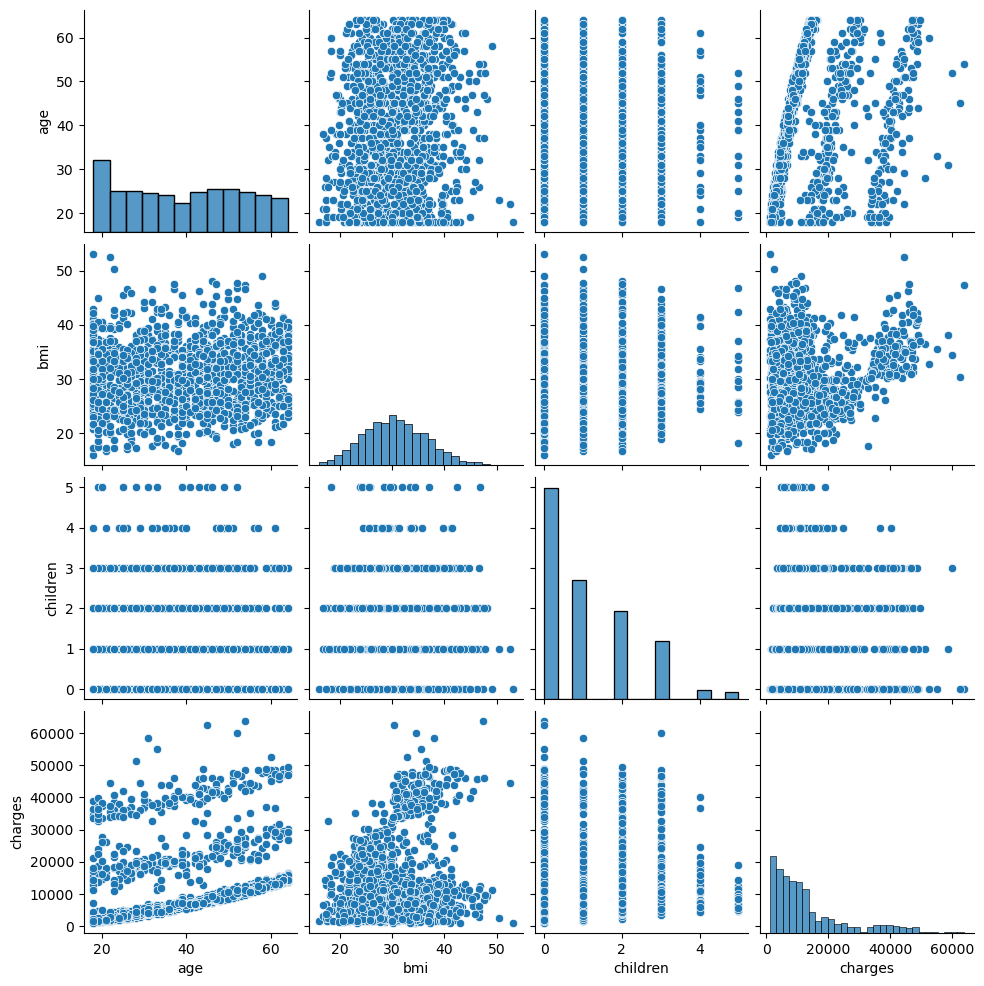

In [124]:
# bivariate
    # relationship plot
        # scatter
        # line

# sns.barplot(data= df,x = 'sex',y='age')
sns.pairplot(df)

<Axes: >

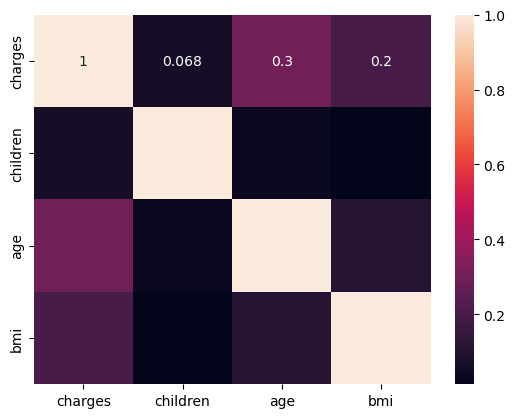

In [136]:
# multivariate

# correlation/heatmap

sns.heatmap(df[numerical].corr(),annot = True)

In [150]:
# transformation

# categorical- 

# categorical_cols

from sklearn.preprocessing import OneHotEncoder

In [152]:
categorical_cols

['sex', 'smoker', 'region']

In [170]:
onehot_encoded

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 1., 0.],
       ...,
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.]])

In [166]:
encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = encoder.fit_transform(df[categorical_cols])
onehot_df = pd.DataFrame(onehot_encoded, columns=encoder.get_feature_names_out(categorical_cols))
df_proc = pd.concat([df, onehot_df], axis=1)

In [168]:
df_proc

,age,sex,bmi,children,smoker,region,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,female,27.900,0,yes,southwest,16884.92400,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18,male,33.770,1,no,southeast,1725.55230,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28,male,33.000,3,no,southeast,4449.46200,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33,male,22.705,0,no,northwest,21984.47061,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32,male,28.880,0,no,northwest,3866.85520,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1334,18,female,31.920,0,no,northeast,2205.98080,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1335,18,female,36.850,0,no,southeast,1629.83350,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1336,21,female,25.800,0,no,southwest,2007.94500,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [196]:
categorical_cols + ['charges']

['sex', 'smoker', 'region', 'charges']

In [192]:
X = df_proc.drop(columns = categorical_cols + ['charges'])
y = df_proc['charges']

In [198]:
X,y

(      age     bmi  children  sex_female  sex_male  smoker_no  smoker_yes  \
 0      19  27.900         0         1.0       0.0        0.0         1.0   
 1      18  33.770         1         0.0       1.0        1.0         0.0   
 2      28  33.000         3         0.0       1.0        1.0         0.0   
 3      33  22.705         0         0.0       1.0        1.0         0.0   
 4      32  28.880         0         0.0       1.0        1.0         0.0   
 ...   ...     ...       ...         ...       ...        ...         ...   
 1333   50  30.970         3         0.0       1.0        1.0         0.0   
 1334   18  31.920         0         1.0       0.0        1.0         0.0   
 1335   18  36.850         0         1.0       0.0        1.0         0.0   
 1336   21  25.800         0         1.0       0.0        1.0         0.0   
 1337   61  29.070         0         1.0       0.0        0.0         1.0   
 
       region_northeast  region_northwest  region_southeast  region_southw

In [206]:
from sklearn.model_selection import train_test_split

In [208]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [210]:
X_train,X_test,y_train,y_test

(      age     bmi  children  sex_female  sex_male  smoker_no  smoker_yes  \
 560    46  19.950         2         1.0       0.0        1.0         0.0   
 1285   47  24.320         0         1.0       0.0        1.0         0.0   
 1142   52  24.860         0         1.0       0.0        1.0         0.0   
 969    39  34.320         5         1.0       0.0        1.0         0.0   
 486    54  21.470         3         1.0       0.0        1.0         0.0   
 ...   ...     ...       ...         ...       ...        ...         ...   
 1095   18  31.350         4         1.0       0.0        1.0         0.0   
 1130   39  23.870         5         1.0       0.0        1.0         0.0   
 1294   58  25.175         0         0.0       1.0        1.0         0.0   
 860    37  47.600         2         1.0       0.0        0.0         1.0   
 1126   55  29.900         0         0.0       1.0        1.0         0.0   
 
       region_northeast  region_northwest  region_southeast  region_southw

In [200]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso

In [202]:
lr = LinearRegression()

In [214]:
lr.fit(X_train,y_train)

LinearRegression()

In [226]:
lr.intercept_,lr.coef_

(-574.5357125101946,
 array([ 2.56975706e+02,  3.37092552e+02,  4.25278784e+02,  9.29584582e+00,
        -9.29584582e+00, -1.18255644e+04,  1.18255644e+04,  4.59585244e+02,
         8.89079180e+01, -1.98279052e+02, -3.50214110e+02]))

In [228]:
y_pred = lr.predict(X_test)

In [232]:
y_test,y_pred

(764      9095.06825
 887      5272.17580
 890     29330.98315
 1293     9301.89355
 259     33750.29180
            ...     
 109     47055.53210
 575     12222.89830
 535      6067.12675
 543     63770.42801
 846      9872.70100
 Name: charges, Length: 268, dtype: float64,
 array([ 8969.55027444,  7068.74744287, 36858.41091155,  9454.67850053,
        26973.17345656, 10864.11316424,   170.28084137, 16903.45028662,
         1092.43093614, 11218.34318352, 28101.68455267,  9377.73460205,
         5263.0595179 , 38416.04221107, 40255.82339284, 37098.25353123,
        15240.39392306, 35912.88264434,  9112.52398703, 31461.92108909,
         3847.68845883, 10130.12001517,  2370.54189389,  7140.21550828,
        11301.76782638, 12961.65366224, 14509.47251876,  6159.8976107 ,
         9963.85857263,  2177.85718217,  9115.93673493, 13073.68932159,
         4561.82376202,  3408.20756033,  4459.81359745, 13032.06505076,
         1979.99357292,  8813.28303302, 33271.29124448, 32585.51583927,
    

In [246]:
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,mean_absolute_percentage_error

In [254]:
print ("mean squared error",mean_squared_error(y_pred,y_test))
print("mean absolute error",mean_absolute_error(y_pred,y_test))
print ("mean abs percentage error",mean_absolute_percentage_error(y_pred,y_test))
print ("r2_score",r2_score(y_pred,y_test))

 33596915.851361476
 4181.194473753645
 0.5829456643852924
 0.7088351277198337


When to use lasso and ridge?
    Lasso minimizes the weights close to 0 or 0 
        thus can be used for feature selection
        and when we have a large number of features and we want few of the features with less relevance to be removed
    Ridge is used when we have lesser number of features or
        we dont want any of the features to be dropped 
    

In [256]:
ridge = Ridge()

In [258]:
ridge

Ridge()

In [272]:
ridge.fit(X_train,y_train)

Ridge()

In [274]:
ridge.predict(X_test)

array([ 8980.22899525,  7078.96608405, 36797.97785131,  9468.72623903,
       26920.59698573, 10879.26021848,   182.8355153 , 16914.22251127,
        1105.20713354, 11231.82818139, 28050.96595352,  9391.67755362,
        5279.41031936, 38365.58507975, 40203.73847555, 37047.87973878,
       15253.7377045 , 35858.60097566,  9127.37873987, 31403.51275517,
        3866.01542182, 10145.49278495,  2388.15909879,  7151.47929312,
       11311.22386634, 12970.49382889, 14518.71473389,  6171.35947076,
        9974.21212655,  2199.0660314 ,  9128.19358223, 13081.71561111,
        4578.31862592,  3420.35063638,  4476.92996333, 13045.0967549 ,
        1993.94086185,  8824.78414478, 33212.4079428 , 32536.41301835,
        3923.24441317,  4341.67509206, 14152.5130584 , 11435.86498354,
        8793.6550298 , 12111.4473312 ,  5293.17700425,  3164.59009789,
       35444.88922039,  9169.57561686, 15849.15836735,  2364.99198055,
       12373.69535735,  1499.20023011, 13406.20770994, 12587.11204525,
      

# 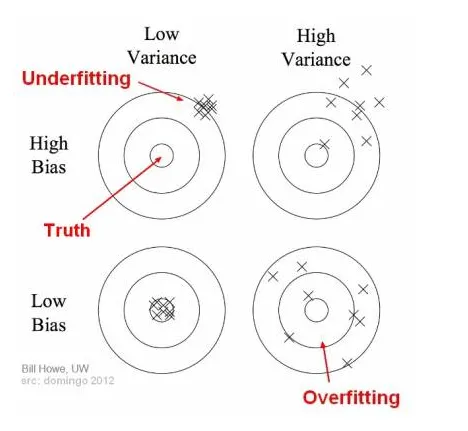
bias variance trade - off

